In [10]:
import os
import zipfile
import shutil
# Directory containing the zip files
directory = "dataset/sharpener"

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".zip"):
        # Extract the base name of the zip file (remove the .zip extension)
        base_foldername = filename[:-4]
        foldername = os.path.join(directory, base_foldername)
        
        # Create a directory with the base name
        os.makedirs(foldername, exist_ok=True)
        
        # Full path of the zip file
        zip_path = os.path.join(directory, filename)
        
        # Unzip the file into the corresponding directory
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for member in zip_ref.namelist():
                # Adjust the path to avoid creating redundant subfolders
                member_path = os.path.join(foldername, os.path.basename(member))
                source = zip_ref.open(member)
                target = open(member_path, "wb")
                with source, target:
                    shutil.copyfileobj(source, target)

print("Unzipping complete.")


Unzipping complete.


In [59]:
import os
import fnmatch

directory = "dataset/sharpener"
pattern = "wrist_rgb*_1.png"  # Adjust the pattern as needed

# Loop through all folders in the directory
for foldername in sorted(os.listdir(directory)):
    folder_path = os.path.join(directory, foldername)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            if fnmatch.fnmatch(filename, pattern):
                file_path = os.path.join(folder_path, filename)
                print(f"Processing file: {file_path}")
                
                # Open the image
                # with Image.open(file_path) as img:
                #     img.show()


Processing file: dataset/sharpener/t0.03_rot15/wrist_rgb_t0.03_rot15_1.png
Processing file: dataset/sharpener/t0.03_rot30/wrist_rgb_t0.03_rot30_1.png
Processing file: dataset/sharpener/t0.03_rot45/wrist_rgb_t0.03_rot45_1.png
Processing file: dataset/sharpener/t0.03_rot60/wrist_rgb_t0.03_rot60_1.png
Processing file: dataset/sharpener/t0.03_rot75/wrist_rgb_t0.03_rot75_1.png
Processing file: dataset/sharpener/t0.06_rot15/wrist_rgb_t0.06_rot15_1.png
Processing file: dataset/sharpener/t0.06_rot30/wrist_rgb_t0.06_rot30_1.png
Processing file: dataset/sharpener/t0.06_rot45/wrist_rgb_t0.06_rot45_1.png
Processing file: dataset/sharpener/t0.06_rot60/wrist_rgb_t0.06_rot60_1.png
Processing file: dataset/sharpener/t0.06_rot75/wrist_rgb_t0.06_rot75_1.png
Processing file: dataset/sharpener/t0.09_rot15/wrist_rgb_t0.09_rot15_1.png
Processing file: dataset/sharpener/t0.09_rot30/wrist_rgb_t0.09_rot30_1.png
Processing file: dataset/sharpener/t0.09_rot45/wrist_rgb_t0.09_rot45_1.png
Processing file: dataset/

In [60]:
from lightglue import LightGlue, SuperPoint, match_pair

ModuleNotFoundError: No module named 'lightglue'

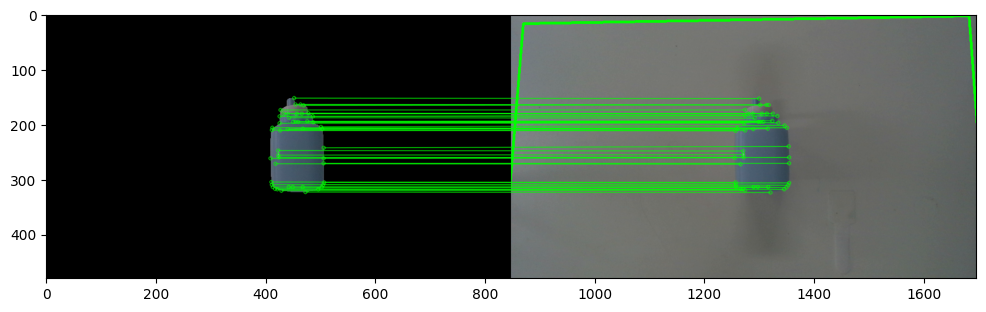

(<matplotlib.image.AxesImage at 0x2876d12d0>, None)

In [161]:
import torch
import numpy as np
import poselib
import cv2
from matplotlib import pyplot as plt
from lightglue import LightGlue, SuperPoint, match_pair

def numpy_image_to_torch(image: np.ndarray) -> torch.Tensor:
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float, device="cpu")

# SuperPoint+LightGlue
extractor = SuperPoint(max_num_keypoints=2048).eval().cpu()  # load the extractor
matcher = LightGlue(features='superpoint', depth_confidence=-1, width_confidence=-1).eval().cpu()  # load the matcher

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

seg = np.array(Image.open("dataset/sharpener/wrist_seg_ref.png")).astype(bool)
im1 = np.array(Image.open("dataset/sharpener/wrist_rgb_ref.png"))  # Original image
im1 *= seg
im2 = np.array(Image.open("dataset/sharpener/t0_rot0/wrist_rgb_t0_rot0_11.png"))
feats0, feats1, matches01 = match_pair(extractor, matcher, numpy_image_to_torch(im1), numpy_image_to_torch(im2))
matches = matches01['matches']  # indices with shape (K,2)
mkpts_0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()  # coordinates in image #0, shape (K,2)
mkpts_1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()  # coordinates in image #1, shape (K,2)
canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas), plt.show()

In [173]:
from scipy.spatial.transform import Rotation

K = np.load("handeye/intrinsics_d405.npy")
camera = {'model': 'PINHOLE', 'width': 848, 'height': 480, 'params': [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]}

# Normalize coordinates
def normalize_points(points, K):
    K_inv = np.linalg.inv(K)
    return (K_inv @ np.hstack((points, np.ones((points.shape[0], 1)))).T).T[:, :2]

# Normalize your points
mkpts_0_norm = normalize_points(mkpts_0, K)
mkpts_1_norm = normalize_points(mkpts_1, K)

# Use RANSAC and check different methods
E, mask = cv2.findEssentialMat(mkpts_0_norm, mkpts_1_norm, np.eye(3), method=cv2.RANSAC, prob=0.999, threshold=0.001)

# Recover pose
n, R, t, _ = cv2.recoverPose(E, mkpts_0_norm, mkpts_1_norm, np.eye(3), mask=mask)

# Scale t to match your known translation magnitude (if available)
known_translation_magnitude = 0.03  # 3cm
t_scaled = t * (known_translation_magnitude / np.linalg.norm(t))

print("Estimated translation:", t_scaled)
print("Estimated rotation (Euler angles):", Rotation.from_matrix(R).as_euler('xyz', degrees=True))

# Check essential matrix properties
U, S, Vt = np.linalg.svd(E)
print("Singular values of E:", S)

M, info = poselib.estimate_relative_pose(
    mkpts_0,
    mkpts_1,
    camera,
    camera,
    {
        "max_epipolar_error": 0.5,
    },
)
print(M, info)

def estimate_pose(kpts0, kpts1, K0, K1, thresh=0.5, conf=0.99999):
    if len(kpts0) < 5:
        return None
    
    # normalize keypoints
    kpts0 = (kpts0 - K0[[0, 1], [2, 2]][None]) / K0[[0, 1], [0, 1]][None]
    kpts1 = (kpts1 - K1[[0, 1], [2, 2]][None]) / K1[[0, 1], [0, 1]][None]

    # normalize ransac threshold
    ransac_thr = thresh / np.mean([K0[0, 0], K1[1, 1], K0[0, 0], K1[1, 1]])

    # compute pose with cv2
    E, mask = cv2.findEssentialMat(
        kpts0, kpts1, np.eye(3), threshold=ransac_thr, prob=conf, method=cv2.RANSAC)
    if E is None:
        print("\nE is None while trying to recover pose.\n")
        return None

    # recover pose from E
    best_num_inliers = 0
    ret = None
    for _E in np.split(E, len(E) / 3):
        n, R, t, _ = cv2.recoverPose(_E, kpts0, kpts1, np.eye(3), 1e9, mask=mask)
        if n > best_num_inliers:
            ret = (R, t[:, 0], mask.ravel() > 0)
            best_num_inliers = n

    return ret

ret = estimate_pose(mkpts_0, mkpts_1, K, K)
print(ret[1] * 0.03, Rotation.from_matrix(ret[0]).as_euler('xyz', degrees=True))


Estimated translation: [[ 0.01732051]
 [-0.01732051]
 [ 0.01732051]]
Estimated rotation (Euler angles): [-9.54166404e-15  0.00000000e+00  7.06225008e-31]
Singular values of E: [7.07106781e-01 7.07106781e-01 1.25409582e-16]
[q:           1 8.62062e-17 1.63742e-17 1.47289e-17, t:  -0.208122   0.977575 -0.0321258] {'refinements': 8, 'iterations': 1001, 'num_inliers': 78, 'inlier_ratio': 1.0, 'model_score': 2.8819763218916796e-33, 'inliers': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]}


TypeError: 'NoneType' object is not subscriptable

In [223]:
H, mask = cv2.findHomography(mkpts_0, mkpts_1, cv2.USAC_MAGSAC, 1, confidence=0.99999)
print(H-H.T)
# Decompose the normalized homography matrix using OpenCV
retval, rotations, translations, normals = cv2.decomposeHomographyMat(H, K)

# Output the results
print("Possible rotations:")
for R, t, n  in zip(rotations, translations, normals):
    if t[2] <= 0:
            continue
    print(Rotation.from_matrix(R).as_euler('xyz', degrees=True), t)

# array([[ 1.02204471e+00, -5.10003519e-02, -5.33751258e-01],
#        [ 2.08373525e-02,  9.69520852e-01, -3.78218144e+00],
#        [ 3.94605466e-05, -9.85480046e-05,  1.00000000e+00]])

[[ 0.         -0.07222454  4.77047348]
 [ 0.07222454  0.          5.03686285]
 [-4.77047348 -5.03686285  0.        ]]
Possible rotations:
[ 0.05542191  0.01362194 -0.25696268] [[0.00574852]
 [0.00806876]
 [0.06905734]]
[-3.71458665 -1.18647873  0.23574355] [[-0.02111399]
 [ 0.06649208]
 [ 0.00026451]]


In [171]:
quat = np.append(M.q[1:], M.q[0])
quat

array([8.62061968e-17, 1.63742058e-17, 1.47289250e-17, 1.00000000e+00])

In [146]:
print(M.t * 0.03, Rotation.from_quat(quat).as_euler('xyz', degrees=True))

[-0.00624366  0.02932725 -0.00096377] [ 9.88573433 14.73248924 17.13457575]


In [236]:
from scipy.spatial.transform import Rotation
from tqdm import tqdm

seg = np.array(Image.open("dataset/sharpener/wrist_seg_ref.png")).astype(bool)
im1 = np.array(Image.open("dataset/sharpener/wrist_rgb_ref.png")) # Original image
im1 *= seg
xfeat = torch.hub.load('verlab/accelerated_features', 'XFeat', pretrained = True, top_k = 2048)
K = np.load("handeye/intrinsics_d405.npy")

camera = {'model': 'PINHOLE', 'width': 848, 'height': 480, 'params': [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]}

t = []
R = []
index_t = 0.03
index_r = 15
for i in tqdm(range(50), desc="Processing"):
    im2 = np.copy(Image.open(f"dataset/sharpener/t{index_t}_rot{index_r}/wrist_rgb_t{index_t}_rot{index_r}_{i+1}.png"))
    im2.show()
    feats0, feats1, matches01 = match_pair(extractor, matcher, numpy_image_to_torch(im1), numpy_image_to_torch(im2))
    matches = matches01['matches']  # indices with shape (K,2)
    mkpts_0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()  # coordinates in image #0, shape (K,2)
    mkpts_1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()  # coordinates in image #1, shape (K,2)
    M, info = poselib.estimate_relative_pose(
        mkpts_0,
        mkpts_1,
        camera,
        camera,
        {
            "max_epipolar_error": 0.5,
        },
    )
    t.append(M.t)
    R.append(Rotation.from_quat(quat).as_euler('xyz', degrees=True))
    print(R)

Using cache found in /Users/yilong/.cache/torch/hub/verlab_accelerated_features_main
Processing:   2%|▏         | 1/50 [00:03<03:10,  3.88s/it]

[array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15])]


Processing:   4%|▍         | 2/50 [00:07<02:46,  3.47s/it]

[array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15])]


Processing:   6%|▌         | 3/50 [00:10<02:36,  3.33s/it]

[array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15])]


Processing:   8%|▊         | 4/50 [00:13<02:31,  3.29s/it]

[array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15])]


Processing:  10%|█         | 5/50 [00:16<02:25,  3.24s/it]

[array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15])]


Processing:  12%|█▏        | 6/50 [00:19<02:20,  3.19s/it]

[array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]), array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15])]


Processing:  12%|█▏        | 6/50 [00:20<02:32,  3.47s/it]


KeyboardInterrupt: 

In [233]:
R = np.array(R)
t = np.array(t)



In [234]:
np.mean(R, axis=0), np.mean(t, axis=0)

(array([9.87850249e-15, 0.00000000e+00, 1.68781047e-15]),
 array([ 0.12402962, -0.15065435,  0.81312968]))

In [235]:
np.std(R, axis=0), np.std(t, axis=0)

(array([3.15544362e-30, 0.00000000e+00, 1.57772181e-30]),
 array([0.37107571, 0.34258663, 0.21469017]))

In [215]:
lg_Essential = {}

lg_Essential["0, 0"] = {"R": R, "t": t}

In [205]:
import pickle

# Save the dictionary to a pickle file
with open("dataset/sharpener/lg_Essential.pkl", "wb") as file:
    pickle.dump(lg_Essential, file)

In [210]:
# Load the dictionary from the pickle file
with open("dataset/sharpener/lg_Essential.pkl", "rb") as file:
    lg_Essential_loaded = pickle.load(file)

# Accessing the loaded data
R_loaded = lg_Essential_loaded["0, 0"]["R"]
t_loaded = lg_Essential_loaded["0, 0"]["t"]

print("Loaded Rotation Matrix R:\n", R_loaded)
print("Loaded Translation Vector t:\n", t_loaded)

Loaded Rotation Matrix R:
 [[9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e